## Algoritms #5
## Градиентный бустинг

1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [11]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [190]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])


# Функциона ошибки MSE

def mean_squared_error(y_real, prediction):    
    return (sum((y_real - prediction)**2)) / len(y_real)


# Loss L-2

def bias(y, z):
    return (y - z)


# Обучение модели Градиентного бустинга

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

# Обучение модели Стохастического Градиентного бустинга

def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, subsample_value=0.5):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
                        
        # генерируем случайную подвыборку
        qtt = int(X_train.shape[0] * subsample_value)
        train_ind = np.random.randint(X_train.shape[0], size=qtt)
    
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[train_ind], y_train[train_ind])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[train_ind], bias(y_train[train_ind], target[train_ind]))
            
            train_errors.append(
                mean_squared_error(
                    y_train, gb_predict(X_train, trees, coefs, eta)
                )
            )
            test_errors.append(
                mean_squared_error(
                    y_test, gb_predict(X_test, trees, coefs, eta)
                )
            )

        trees.append(tree)
        
    return trees, train_errors, test_errors


# Вывод информации о работе алгоритма

def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [191]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.3 на тренировочной выборке: 1753.5731453431968
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.3 на тестовой выборке: 3459.972997960725


In [192]:
trees, train_errors, test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.3 на тренировочной выборке: 2123.893685871668
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.3 на тестовой выборке: 3708.1481931493213


In [171]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.3

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [183]:
def get_err_plots(n_trees_min, n_trees_max, max_depth_min, max_depth_max, eta, model):
    
    n_trees = np.linspace(n_trees_min, n_trees_max, 5, dtype='int8')
    max_depth = np.linspace(max_depth_min, max_depth_max, 5, dtype='int8')

    
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4)
    f.set_figheight(20)
    f.set_figwidth(16)
    

    
    
    for i in range(len(n_trees)):
        coefs = [1] * n_trees[i]
        trees, train_errors, test_errors = model(n_trees[i],
                                                3, X_train, X_test,
                                                y_train, y_test, coefs, eta)

        ax1.plot(list(range(len(trees))), train_errors, label=f'n_trees={n_trees[i]}, max_depth=3')
        ax1.legend(loc="upper right")
        ax1.set_title('Train n_trees dependance')
        ax1.set_xlabel('iteration number')
        ax1.set_ylabel('MSE')
        
        ax2.plot(list(range(len(trees))), test_errors, label=f'n_trees={n_trees[i]}, max_depth=3')
        ax2.legend(loc="upper right")
        ax2.set_title('Test n_trees dependance')
        ax2.set_xlabel('iteration number')
        ax2.set_ylabel('MSE')
        
        
        
        trees, train_errors, test_errors = model(10,
                                                max_depth[i], X_train, X_test,
                                                y_train, y_test, coefs, eta)
        
        ax3.plot(list(range(len(trees))), train_errors, label=f'n_trees=10, max_depth={max_depth[i]}')
        ax3.legend(loc="upper right")
        ax3.set_title('Train max_depth dependance')
        ax3.set_xlabel('iteration number')
        ax3.set_ylabel('MSE')
        
        ax4.plot(list(range(len(trees))), test_errors, label=f'n_trees=10, max_depth={max_depth[i]}')
        ax4.legend(loc="upper right")
        ax4.set_title('Test max_depth dependance')
        ax4.set_xlabel('iteration number')
        ax4.set_ylabel('MSE')
        

    
    plt.show()

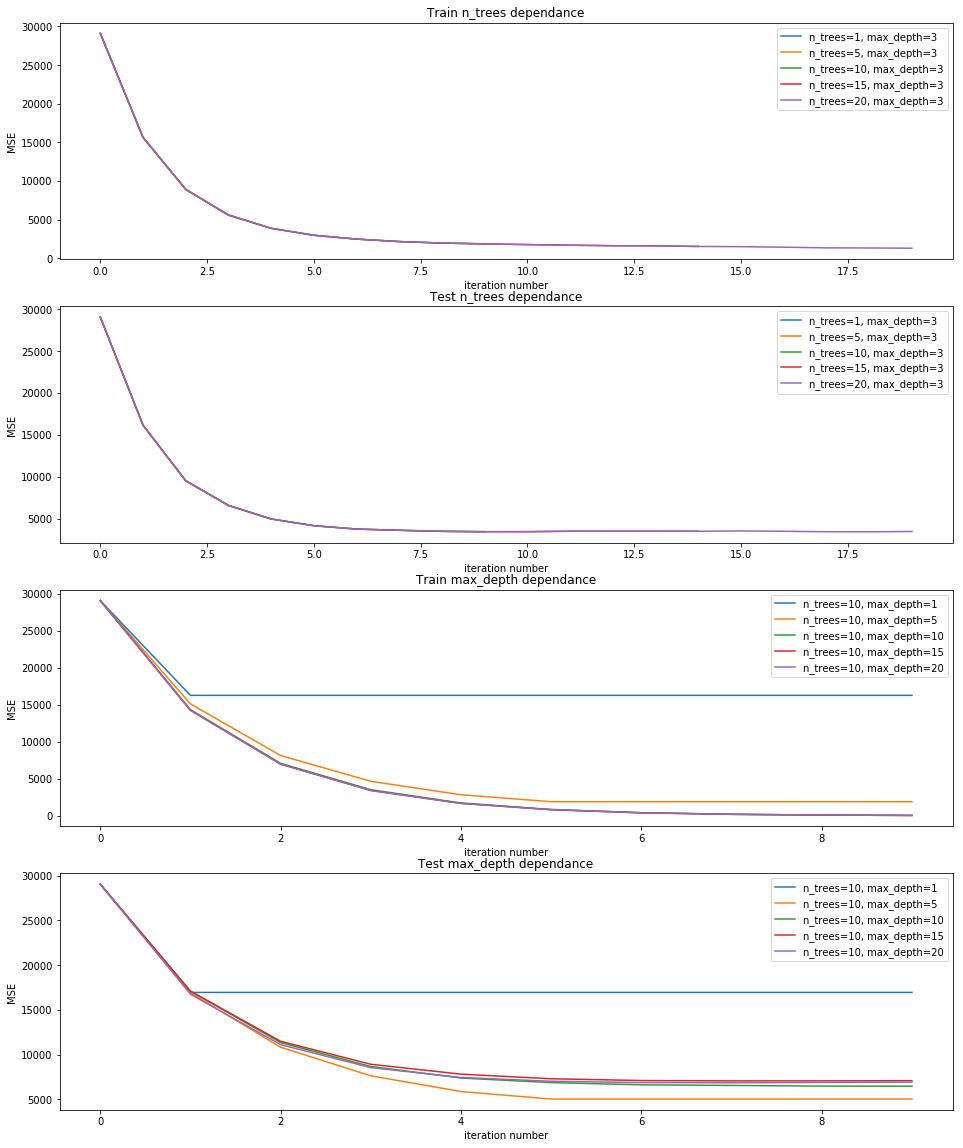

In [184]:
n_trees_min = 1
n_trees_max = 20
max_depth_min = 1
max_depth_max = 20

get_err_plots(n_trees_min, n_trees_max, max_depth_min, max_depth_max, eta, model=gb_fit)

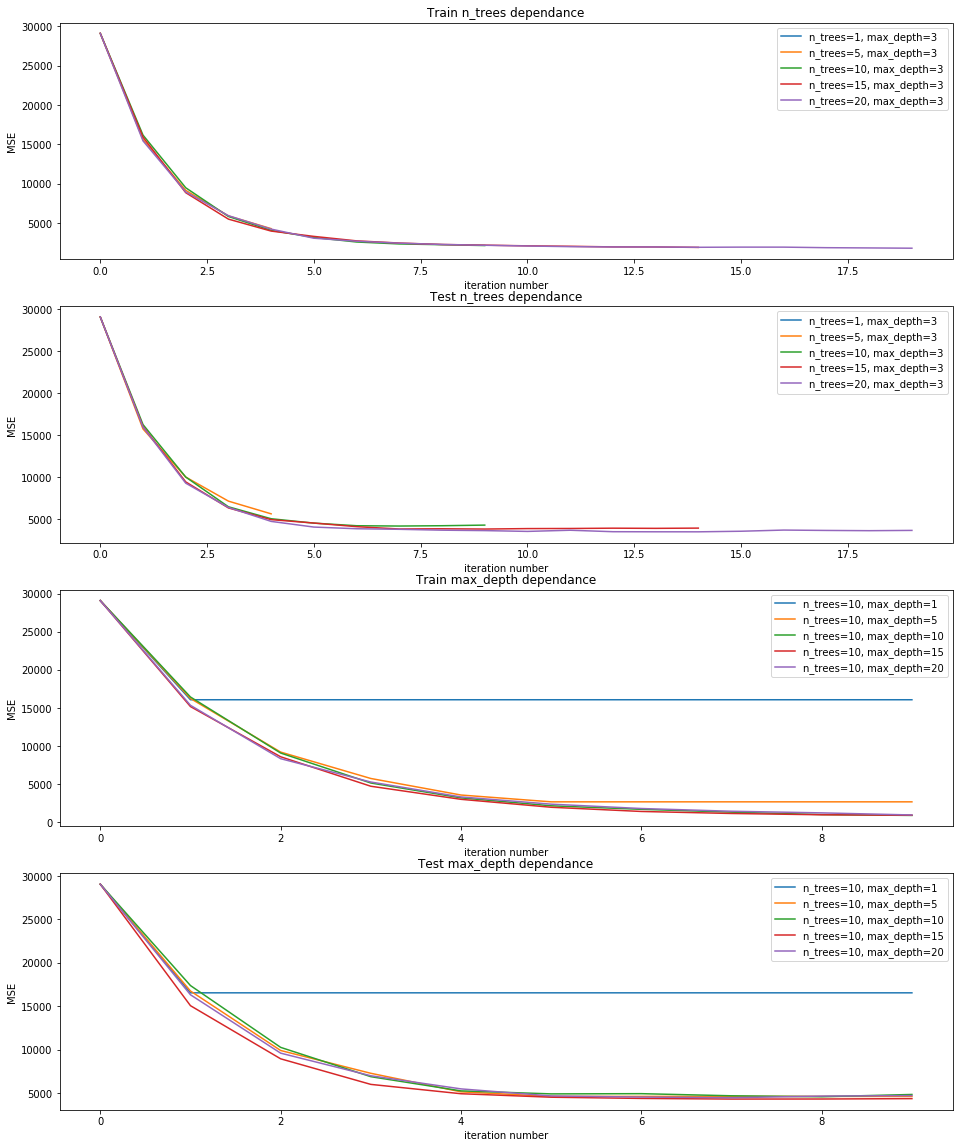

In [193]:
# Повтор на модели Стохастического градиентного бустинга

n_trees_min = 1
n_trees_max = 20
max_depth_min = 1
max_depth_max = 20

get_err_plots(n_trees_min, n_trees_max, max_depth_min, max_depth_max, eta, model=sgb_fit)

Выводы: При увеличении количества деревьев (с учетом заданного диапазона), ошибка уменьшается как на тренеровочной, так и на тестовой выборке. Увеличение глубины может привести к переобучению.